Target Return: 0.0060

Portfolio Optimization Results:
--------------------------------------------------
Status: Optimal

Expected Portfolio Return: 0.0060
MAD Risk Measure: 0.0283

Optimal Weights:
                         Weight
Coal India Ltd..1     0.961016
Hero Motocorp Ltd..1  0.038984


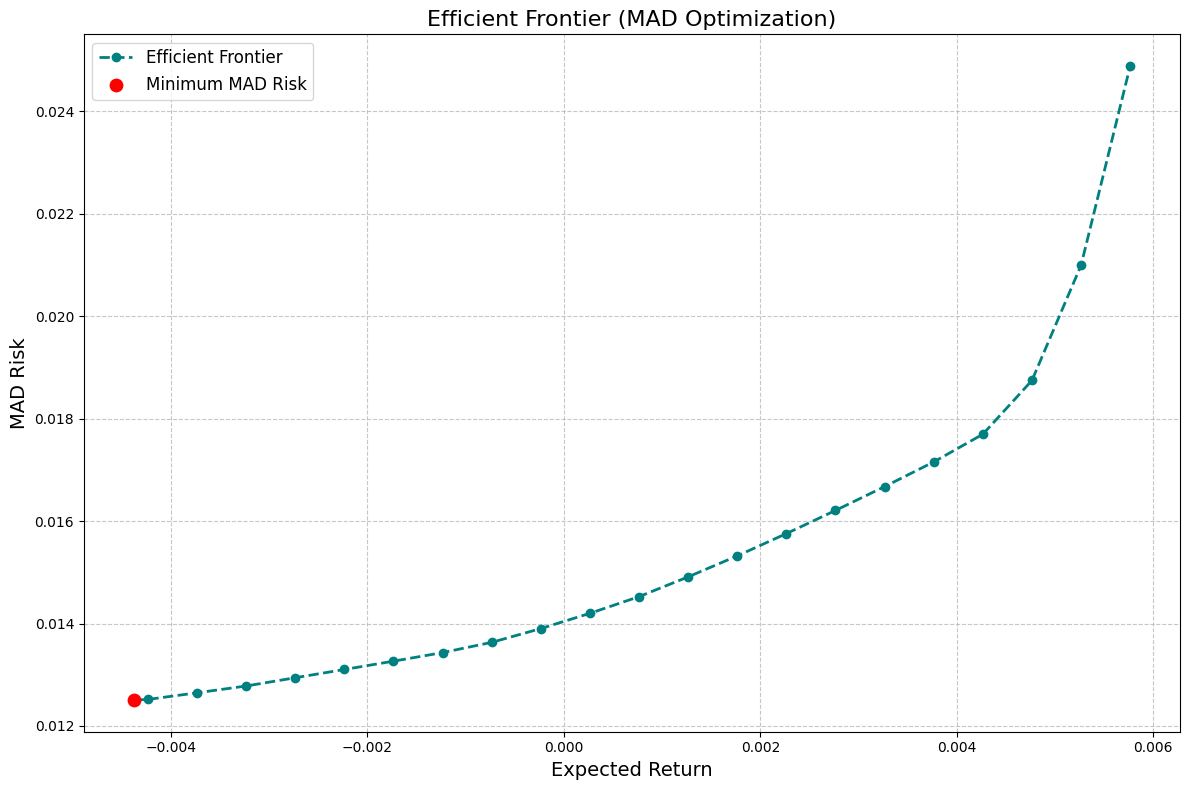

In [1]:
import pandas as pd
from pulp import *
import matplotlib.pyplot as plt
import numpy as np

# Function to process financial data from an Excel file
def load_and_clean_data(file_path):
    # Load Excel data into a DataFrame
    xls = pd.ExcelFile(file_path)
    df = xls.parse('Sheet1')
    
    # Remove fully empty rows and columns
    df.dropna(how='all', inplace=True)
    df.dropna(axis=1, how='all', inplace=True)
    
    # Extract the date column and convert to datetime
    date_column = df.iloc[:, 0]
    dates = pd.to_datetime(date_column, errors='coerce')
    
    # Separate columns into prices and returns based on the ".1" suffix
    price_columns = [col for col in df.columns if not str(col).endswith('.1')]
    returns_columns = [col for col in df.columns if str(col).endswith('.1')]
    
    # Create DataFrames for prices and returns
    prices_df = df[price_columns].copy()
    returns_df = df[returns_columns].copy()
    
    # Assign dates to both DataFrames and remove rows with invalid dates
    prices_df.insert(0, 'Date', dates)
    returns_df.insert(0, 'Date', dates)
    prices_df.dropna(subset=['Date'], inplace=True)
    returns_df.dropna(subset=['Date'], inplace=True)
    
    return prices_df[:37], returns_df[:37]

# Function to clean the returns DataFrame
def prepare_returns_data(returns_df):
    cleaned_df = returns_df.dropna()
    return cleaned_df.drop(['Date', 'Market Portfolio.1'], axis=1)

# Function to perform MAD portfolio optimization
def mad_portfolio_optimization(returns_df, target_return):
    asset_returns = prepare_returns_data(returns_df)
    mean_returns = asset_returns.mean()
    
    # Set up the optimization problem
    prob = LpProblem("MAD_Portfolio_Optimization", LpMinimize)
    asset_weights = LpVariable.dicts("weights", asset_returns.columns, lowBound=0, upBound=1)
    n_periods = len(asset_returns)
    
    # Create y variables for absolute deviation calculations
    y = LpVariable.dicts("y", range(n_periods), lowBound=0)
    
    # Objective: Minimize average deviation from mean returns
    prob += lpSum(y[i] for i in range(n_periods)) / n_periods

    # Constraint: Sum of weights should be 1
    prob += lpSum(asset_weights[asset] for asset in asset_returns.columns) == 1

    # Constraint: Portfolio should achieve at least the target return
    prob += lpSum(asset_weights[asset] * mean_returns[asset] for asset in asset_returns.columns) >= target_return

    # Absolute deviation constraints for each period
    for period in range(n_periods):
        period_returns = asset_returns.iloc[period]
        mean_portfolio_return = lpSum(asset_weights[asset] * mean_returns[asset] for asset in asset_returns.columns)
        portfolio_return_period = lpSum(asset_weights[asset] * period_returns[asset] for asset in asset_returns.columns)
        
        prob += portfolio_return_period - mean_portfolio_return <= y[period]
        prob += -portfolio_return_period + mean_portfolio_return <= y[period]

    # Solve the optimization problem
    prob.solve()

    # Extract results
    if LpStatus[prob.status] == 'Optimal':
        optimal_weights = {asset: value(asset_weights[asset]) for asset in asset_returns.columns}
        portfolio_return = sum(optimal_weights[asset] * mean_returns[asset] for asset in asset_returns.columns)
        portfolio_mad = value(prob.objective)
        
        return {
            'weights': optimal_weights,
            'portfolio_return': portfolio_return,
            'portfolio_mad': portfolio_mad,
            'status': LpStatus[prob.status]
        }
    else:
        return {
            'status': LpStatus[prob.status],
            'message': 'No solution found'
        }

# Function to display the portfolio optimization results
def display_optimization_results(results):
    print("\nPortfolio Optimization Results:")
    print("-" * 50)
    print(f"Status: {results['status']}")
    
    if results['status'] == 'Optimal':
        print(f"\nExpected Portfolio Return: {results['portfolio_return']:.4f}")
        print(f"MAD Risk Measure: {results['portfolio_mad']:.4f}")
        
        weights_df = pd.DataFrame.from_dict(results['weights'], orient='index', columns=['Weight'])
        weights_df = weights_df[weights_df['Weight'] > 0.0001].sort_values('Weight', ascending=False)
        print("\nOptimal Weights:\n", weights_df)
    else:
        print("\nSolution could not be determined")

# Function to plot the efficient frontier
def plot_efficient_frontier(returns_df, min_return, max_return, step_size=0.0005):
    target_returns = np.arange(min_return, max_return, step_size)
    mad_risks, portfolio_returns = [], []

    for target in target_returns:
        results = mad_portfolio_optimization(returns_df, target)
        if results['status'] == 'Optimal':
            mad_risks.append(results['portfolio_mad'])
            portfolio_returns.append(results['portfolio_return'])
        else:
            mad_risks.append(np.nan)
            portfolio_returns.append(np.nan)

    # Enhanced Plotting
    plt.figure(figsize=(12, 8))

    # Plot the efficient frontier with markers
    plt.plot(portfolio_returns, mad_risks, 
             label='Efficient Frontier', 
             color='teal', 
             linestyle='--', 
             marker='o', 
             markersize=6, 
             linewidth=2)

    # Highlight the minimum MAD risk point
    if len(mad_risks) > 0 and len(portfolio_returns) > 0:
        min_mad_index = np.nanargmin(mad_risks)
        plt.scatter(portfolio_returns[min_mad_index], mad_risks[min_mad_index], 
                    color='red', 
                    label='Minimum MAD Risk', 
                    s=80, 
                    zorder=5)

    # Labels and grid
    plt.xlabel('Expected Return', fontsize=14)
    plt.ylabel('MAD Risk', fontsize=14)
    plt.title('Efficient Frontier (MAD Optimization)', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Legend and annotations
    plt.legend(loc='best', fontsize=12)
    
    # Show the plot
    plt.tight_layout()
    plt.show()


# Load data and process it
file_path = 'FinanceDataForAssignment (2).xlsx'
prices_df, returns_df = load_and_clean_data(file_path)

# Drop unnecessary columns if present
prices_df.drop(columns=[col for col in prices_df.columns if 'Unnamed' in col], inplace=True)
returns_df.drop(columns=[col for col in returns_df.columns if 'Unnamed' in col], inplace=True)

target_return = 0.006
print(f"Target Return: {target_return:.4f}")
results = mad_portfolio_optimization(returns_df, target_return)
display_optimization_results(results)

min_return = prepare_returns_data(returns_df).mean().min()
max_return = prepare_returns_data(returns_df).mean().max()
plot_efficient_frontier(returns_df, min_return, max_return)
